# 🏴‍☠️ AN2DL25 Challenge 1 — Pirate Pain Classification

This notebook implements a full deep-learning pipeline for multivariate time-series classification of the Pirate Pain dataset. It is inspired by the Lecture 4 notebook (`Timeseries Classification (1).ipynb`) but adapted for the competition setting, including data preparation, model training (RNN/GRU/LSTM variants), evaluation, and test-time inference.



In [726]:
# %%capture
# !pip install -q -r requirements.txt




In [727]:
import os
import random
import math
import copy
from pathlib import Path
from typing import Tuple, Dict, Optional, List, Any
from datetime import datetime
from itertools import product
import inspect

import numpy as np
import pandas as pd
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

try:
    from torch.amp import autocast, GradScaler
except ImportError:  # pragma: no cover
    from torch.cuda.amp import autocast, GradScaler



In [728]:
SEED = 2025

try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except ImportError:  # pragma: no cover
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive', force_remount=False)
    BASE_DIR = Path('/content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge')
else:
    BASE_DIR = Path('/Users/md101ta/Desktop/Pirates')

DATA_DIR = (BASE_DIR / 'data').resolve()
# subito dopo aver definito DATA_DIR in cella 3
DATA_DIR_CANDIDATES = [
    Path('/content/drive/MyDrive/[2025-2026] AN2DL/Challenge'),
    Path('/content/drive/MyDrive/[2025-2026]\\ A2NDL/Challenge'),
    BASE_DIR / 'data'
]

for candidate in DATA_DIR_CANDIDATES:
    if candidate.exists():
        DATA_DIR = candidate
        break
else:
    raise FileNotFoundError('Nessuna DATA_DIR valida trovata')

print(f'Usando DATA_DIR: {DATA_DIR}')
OUTPUT_DIR = (BASE_DIR / 'outputs').resolve()
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    DEVICE = torch.device('cuda')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    DEVICE = torch.device('cpu')

print(f'Running in Colab: {IN_COLAB}')
print(f'Device: {DEVICE}')
print(f'Data dir: {DATA_DIR}')
print(f'Output dir: {OUTPUT_DIR}')

_AUTocast_params = inspect.signature(autocast).parameters
_GRADSCALER_PARAMS = inspect.signature(GradScaler).parameters

def autocast_context():
    enabled = DEVICE.type == 'cuda'
    if 'device_type' in _AUTocast_params:
        return autocast(device_type=DEVICE.type, enabled=enabled)
    if 'device' in _AUTocast_params:
        return autocast(DEVICE.type, enabled=enabled)
    # fallback to legacy signature (enabled only)
    return autocast(enabled=enabled)


def create_grad_scaler():
    enabled = DEVICE.type == 'cuda'
    if 'device_type' in _GRADSCALER_PARAMS:
        return GradScaler(device_type=DEVICE.type, enabled=enabled)
    return GradScaler(enabled=enabled)

<>:11: SyntaxWarning: invalid escape sequence '\ '
<>:11: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1665548672.py:11: SyntaxWarning: invalid escape sequence '\ '
  BASE_DIR = Path('/content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Usando DATA_DIR: /content/drive/MyDrive/[2025-2026] AN2DL/Challenge
Running in Colab: True
Device: cuda
Data dir: /content/drive/MyDrive/[2025-2026] AN2DL/Challenge
Output dir: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs


In [729]:
LOG_DIR = (OUTPUT_DIR / 'logs').resolve()
CHECKPOINT_DIR = (OUTPUT_DIR / 'checkpoints').resolve()
LOG_DIR.mkdir(exist_ok=True, parents=True)
CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True)



In [730]:
from typing import Tuple

assert DATA_DIR.exists(), f"DATA_DIR non esiste: {DATA_DIR}"

def load_data(data_dir: Path) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_train = pd.read_csv(data_dir / 'pirate_pain_train.csv')
    y_train = pd.read_csv(data_dir / 'pirate_pain_train_labels.csv')
    X_test  = pd.read_csv(data_dir / 'pirate_pain_test.csv')
    return X_train, y_train, X_test

# Carica i dati
X_train_raw, y_train, X_test_raw = load_data(DATA_DIR)
print(X_train_raw.shape, y_train.shape, X_test_raw.shape)




(105760, 40) (661, 2) (211840, 40)


In [731]:
# -- Data profiling & feature diagnostics -------------------------------------------------
REPORT_DIR = (OUTPUT_DIR / 'reports').resolve()
REPORT_DIR.mkdir(exist_ok=True, parents=True)

X_train_raw = X_train_raw.sort_values(['sample_index', 'time']).reset_index(drop=True)
X_test_raw = X_test_raw.sort_values(['sample_index', 'time']).reset_index(drop=True)

FEATURE_BASE_COLUMNS = [col for col in X_train_raw.columns if col not in ['sample_index', 'time']]
NUMERIC_FEATURE_BASE_COLUMNS = X_train_raw[FEATURE_BASE_COLUMNS].select_dtypes(include=[np.number]).columns.tolist()
feature_audit_entries: List[Dict[str, Any]] = []

if not NUMERIC_FEATURE_BASE_COLUMNS:
    raise RuntimeError('Nessuna feature numerica trovata per il profiling. Verifica il caricamento dati.')

def save_report(df: pd.DataFrame, filename: str):
    output_path = REPORT_DIR / filename
    df.to_csv(output_path)
    print(f"Salvato report: {output_path}")

# Statistiche descrittive
feature_describe = X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS].describe().T
save_report(feature_describe, 'feature_describe.csv')

# Missing values
missing_info = pd.DataFrame({
    'missing_count': X_train_raw[FEATURE_BASE_COLUMNS].isna().sum(),
    'missing_ratio': X_train_raw[FEATURE_BASE_COLUMNS].isna().mean(),
})
save_report(missing_info, 'feature_missing.csv')

# Varianza
variance_info = X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS].var().to_frame(name='variance')
save_report(variance_info, 'feature_variance.csv')

# Correlazioni (assolute)
corr_matrix = X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS].corr().abs()
save_report(corr_matrix, 'feature_correlation.csv')

# Outlier ratio (valori oltre 5 sigma)
feature_means = X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS].mean()
feature_stds = X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS].std() + 1e-8
z_scores = np.abs((X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS] - feature_means) / feature_stds)
outlier_ratio = (z_scores > 5).sum().div(len(X_train_raw)).to_frame(name='outlier_ratio')
save_report(outlier_ratio, 'feature_outlier_ratio.csv')

print('Profiling completato. Totale feature analizzate:', len(FEATURE_BASE_COLUMNS))



Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_describe.csv
Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_missing.csv
Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_variance.csv
Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_correlation.csv
Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_outlier_ratio.csv
Profiling completato. Totale feature analizzate: 38


Removing features: ['joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_23', 'joint_24', 'joint_30', 'n_eyes', 'n_hands']
Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_removal_log.csv
Time steps (raw): 160 | Window size: 25 | Features: 39 | Classes: 3
Category mappings: {'n_legs': {'one+peg_leg': 0, 'two': 1}, 'n_hands': {'one+hook_hand': 0, 'two': 1}, 'n_eyes': {'one+eye_patch': 0, 'two': 1}}


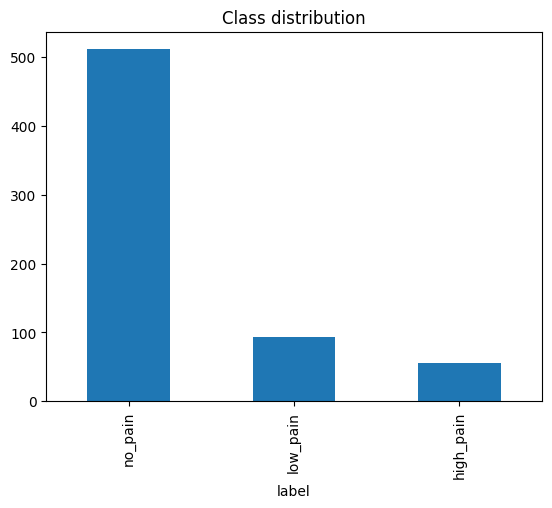

In [732]:
CATEGORICAL_COLUMNS = ['n_legs', 'n_hands', 'n_eyes']
CATEGORY_MAPPINGS: Dict[str, Dict[str, int]] = {}

for col in CATEGORICAL_COLUMNS:
    uniques = pd.concat([X_train_raw[col], X_test_raw[col]]).dropna().unique()
    mapping = {value: idx for idx, value in enumerate(sorted(uniques))}
    CATEGORY_MAPPINGS[col] = mapping
    X_train_raw[col] = X_train_raw[col].map(mapping).astype(np.int32)
    X_test_raw[col] = X_test_raw[col].map(mapping).astype(np.int32)

FEATURE_COLUMNS = [col for col in X_train_raw.columns if col not in ['sample_index', 'time']]

LOW_VARIANCE_THRESHOLD = 2e-3
LOW_MAG_THRESHOLD = 1e-3
HIGH_CORR_THRESHOLD = 0.98

feature_std = X_train_raw[FEATURE_COLUMNS].std()
feature_abs_max = X_train_raw[FEATURE_COLUMNS].abs().max()

# Helper per loggare le feature rimosse

def log_feature_removal(feature: str, reason: str, metric_value: Optional[float] = None, notes: Optional[str] = None):
    entry = {
        'feature': feature,
        'reason': reason,
        'metric': metric_value,
        'notes': notes,
    }
    feature_audit_entries.append(entry)

# Colonne costanti
constant_features = [col for col in FEATURE_COLUMNS if X_train_raw[col].nunique(dropna=False) <= 1]
for feature in constant_features:
    log_feature_removal(feature, 'constant_value', X_train_raw[feature].iloc[0])

# Bassa varianza
low_variance = feature_std[feature_std <= LOW_VARIANCE_THRESHOLD]
for feature, value in low_variance.items():
    log_feature_removal(feature, 'low_variance', float(value))

# Bassa magnitudo
low_magnitude = feature_abs_max[feature_abs_max <= LOW_MAG_THRESHOLD]
for feature, value in low_magnitude.items():
    log_feature_removal(feature, 'low_magnitude', float(value))

# Alta correlazione
corr_matrix = X_train_raw[FEATURE_COLUMNS].corr().abs()
upper_mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_corr = corr_matrix.where(upper_mask)
high_corr_features = set()
for col in upper_corr.columns:
    partners = upper_corr.index[upper_corr[col] >= HIGH_CORR_THRESHOLD].tolist()
    if partners:
        high_corr_features.add(col)
        joined_partners = ','.join(partners)
        log_feature_removal(col, 'high_correlation', notes=f'correlated_with={joined_partners}')

# Outlier-dominated features (opzionale, threshold conservativo)
outlier_flagged = outlier_ratio[outlier_ratio['outlier_ratio'] >= 0.75].index.tolist()
for feature in outlier_flagged:
    log_feature_removal(feature, 'extreme_outliers', float(outlier_ratio.loc[feature, 'outlier_ratio']))

features_to_drop = sorted(set(constant_features) | set(low_variance.index) | set(low_magnitude.index) | high_corr_features | set(outlier_flagged))
if features_to_drop:
    print("Removing features:", features_to_drop)
    X_train_raw = X_train_raw.drop(columns=features_to_drop)
    X_test_raw = X_test_raw.drop(columns=features_to_drop)
    FEATURE_COLUMNS = [col for col in FEATURE_COLUMNS if col not in features_to_drop]

    removal_df = pd.DataFrame(feature_audit_entries)
    if not removal_df.empty:
        save_report(removal_df, 'feature_removal_log.csv')
else:
    print('Nessuna feature rimossa con i criteri impostati.')
    removal_df = pd.DataFrame(feature_audit_entries)
    save_report(removal_df, 'feature_removal_log.csv')

FULL_TIME_STEPS = X_train_raw['time'].nunique()
WINDOW_SIZE = 25
WINDOW_STRIDE = 15
EVAL_WINDOW_SIZE = WINDOW_SIZE
EVAL_WINDOW_STRIDE = WINDOW_STRIDE
EVAL_AGGREGATION = 'logsumexp'
if WINDOW_SIZE > FULL_TIME_STEPS:
    raise ValueError(
        f'Requested window size ({WINDOW_SIZE}) exceeds the available time steps ({FULL_TIME_STEPS}).'
    )
TIME_STEPS = FULL_TIME_STEPS

TIME_DIVISOR = max(FULL_TIME_STEPS - 1, 1)
TIME_FEATURE_COLUMNS = ['time_fraction', 'time_sin', 'time_cos', 'time_is_start', 'time_is_end']
for df in (X_train_raw, X_test_raw):
    frac = (df['time'] / TIME_DIVISOR).astype(np.float32)
    df['time_fraction'] = frac
    df['time_sin'] = np.sin(2 * np.pi * frac).astype(np.float32)
    df['time_cos'] = np.cos(2 * np.pi * frac).astype(np.float32)
    df['time_is_start'] = (df['time'] == 0).astype(np.float32)
    df['time_is_end'] = (df['time'] == FULL_TIME_STEPS - 1).astype(np.float32)

for col in TIME_FEATURE_COLUMNS:
    if col not in FEATURE_COLUMNS:
        FEATURE_COLUMNS.append(col)

TEMPORAL_WINDOW_SIZES = (5, 15)
VALUE_FEATURE_COLUMNS = [col for col in FEATURE_COLUMNS if col not in (TIME_FEATURE_COLUMNS + CATEGORICAL_COLUMNS)]

def add_temporal_statistics(df: pd.DataFrame):
    if not VALUE_FEATURE_COLUMNS:
        return
    df_signal = df[VALUE_FEATURE_COLUMNS].abs().mean(axis=1)
    df['signal_abs_mean'] = df_signal
    if 'signal_abs_mean' not in FEATURE_COLUMNS:
        FEATURE_COLUMNS.append('signal_abs_mean')
    for window in TEMPORAL_WINDOW_SIZES:
        rolling_mean = (
            df.groupby('sample_index')['signal_abs_mean']
              .transform(lambda x: x.rolling(window, min_periods=1, center=True).mean())
        )
        rolling_std = (
            df.groupby('sample_index')['signal_abs_mean']
              .transform(lambda x: x.rolling(window, min_periods=1, center=True).std().fillna(0.0))
        )
        df[f'signal_mean_w{window}'] = rolling_mean
        df[f'signal_std_w{window}'] = rolling_std
        for feature in (f'signal_mean_w{window}', f'signal_std_w{window}'):
            if feature not in FEATURE_COLUMNS:
                FEATURE_COLUMNS.append(feature)

for dataset in (X_train_raw, X_test_raw):
    add_temporal_statistics(dataset)

NUM_FEATURES = len(FEATURE_COLUMNS)
NUM_CLASSES = y_train['label'].nunique()
print(
    f'Time steps (raw): {FULL_TIME_STEPS} | Window size: {WINDOW_SIZE} | Features: {NUM_FEATURES} | Classes: {NUM_CLASSES}'
)
print('Category mappings:', CATEGORY_MAPPINGS)

y_train['label'].value_counts().plot(kind='bar', title='Class distribution')
plt.show()



Feature pain_survey_1: miglior lag ≈ 6 con autocorr 0.008
Feature pain_survey_2: miglior lag ≈ 1 con autocorr 0.008
Feature pain_survey_3: miglior lag ≈ 1 con autocorr 0.012


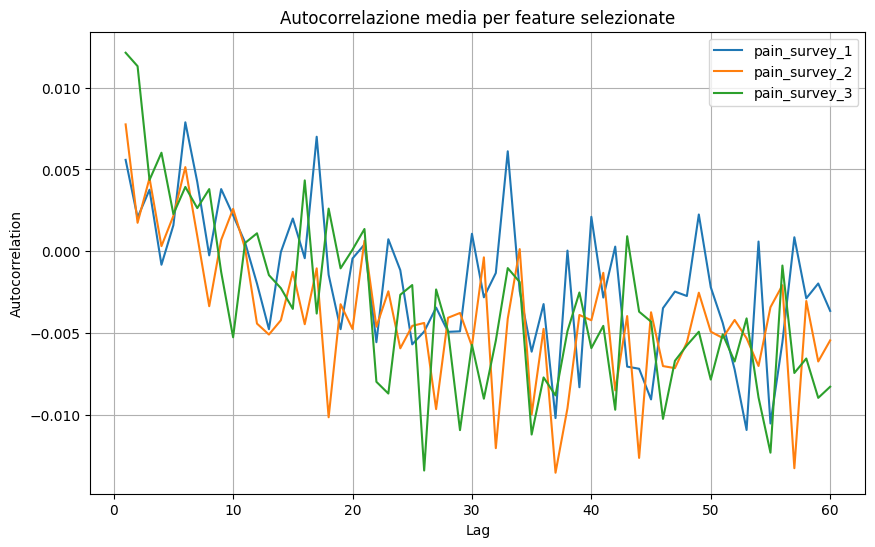

In [733]:
# -- Analisi autocorrelazione per suggerire window size ----------------------
def compute_autocorr_for_feature(feature: str, max_lag: int = 60) -> Tuple[List[int], List[float]]:
    pivot = (
        X_train_raw
        .pivot(index='sample_index', columns='time', values=feature)
        .sort_index(axis=1)
    )
    lags = list(range(1, max_lag + 1))
    autocorr_values: List[float] = []
    for lag in lags:
        ac_series = pivot.apply(lambda row: row.autocorr(lag=lag), axis=1).dropna()
        autocorr_values.append(ac_series.mean() if not ac_series.empty else 0.0)
    return lags, autocorr_values

AUTO_CORR_FEATURES = FEATURE_COLUMNS[:min(3, len(FEATURE_COLUMNS))]
MAX_AUTOCORR_LAG = 60
plt.figure(figsize=(10, 6))
for feature in AUTO_CORR_FEATURES:
    lags, autocorr_vals = compute_autocorr_for_feature(feature, MAX_AUTOCORR_LAG)
    plt.plot(lags, autocorr_vals, label=feature)
    top_lag = lags[int(np.argmax(autocorr_vals))]
    print(f"Feature {feature}: miglior lag ≈ {top_lag} con autocorr {max(autocorr_vals):.3f}")

plt.title('Autocorrelazione media per feature selezionate')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()



In [734]:
# -- Sanity checks per garantire coerenza pipeline ---------------------------
def run_quick_sanity_checks():
    train_cols = set(X_train_raw.columns)
    test_cols = set(X_test_raw.columns)
    assert train_cols == test_cols, 'Train/Test hanno colonne diverse'
    assert len(FEATURE_COLUMNS) == len(set(FEATURE_COLUMNS)), 'FEATURE_COLUMNS contiene duplicati'
    assert all(col in train_cols for col in FEATURE_COLUMNS), 'Colonne feature non presenti nel dataset'
    assert NUM_FEATURES == len(FEATURE_COLUMNS), 'NUM_FEATURES non allineato'
    print('Sanity checks superati: dataset e feature set coerenti.')

run_quick_sanity_checks()



Sanity checks superati: dataset e feature set coerenti.


In [735]:
LABEL2IDX = {label: idx for idx, label in enumerate(sorted(y_train['label'].unique()))}
IDX2LABEL = {idx: label for label, idx in LABEL2IDX.items()}
print('Label mapping:', LABEL2IDX)

HIGH_PAIN_LABELS = [label for label in LABEL2IDX if 'high' in label.lower()]
LOW_PAIN_LABELS = [label for label in LABEL2IDX if 'low' in label.lower()]
NO_PAIN_LABELS = [label for label in LABEL2IDX if 'no' in label.lower()]
HIGH_PAIN_IDX = {LABEL2IDX[label] for label in HIGH_PAIN_LABELS}
LOW_PAIN_IDX = {LABEL2IDX[label] for label in LOW_PAIN_LABELS}
NO_PAIN_IDX = {LABEL2IDX[label] for label in NO_PAIN_LABELS}
print('High-pain classes for augmentation:', HIGH_PAIN_LABELS or 'None')
print('Low-pain classes for augmentation:', LOW_PAIN_LABELS or 'None')
print('No-pain classes for augmentation:', NO_PAIN_IDX or 'None')

HIGH_PAIN_OVERSAMPLE = 2 if HIGH_PAIN_IDX else 1
LOW_PAIN_OVERSAMPLE = 2 if LOW_PAIN_IDX else 1
HIGH_PAIN_WEIGHT_SCALE = 0.15
LOW_PAIN_WEIGHT_SCALE = 0.465
NO_PAIN_WEIGHT_SCALE = 2.6
HIGH_PAIN_AUGMENTATION_PARAMS = {
    'jitter_std': 0.03,
    'scale_range': (0.90, 1.10),
    'time_mask_prob': 0.30,
    'time_mask_ratio': 0.12,
    'time_shift_range': 4,
    'time_flip_prob': 0.10,
}
LOW_PAIN_AUGMENTATION_PARAMS = {
    'jitter_std': 0.02,
    'scale_range': (0.95, 1.05),
    'time_mask_prob': 0.20,
    'time_mask_ratio': 0.08,
    'time_shift_range': 3,
    'time_flip_prob': 0.05,
}
AUGMENTATION_PARAMS = HIGH_PAIN_AUGMENTATION_PARAMS


def pivot_timeseries(df: pd.DataFrame) -> np.ndarray:
    pivoted = (
        df.pivot(index='sample_index', columns='time', values=FEATURE_COLUMNS)
          .sort_index(axis=0)
          .sort_index(axis=1, level=1)
    )
    data = pivoted.to_numpy().reshape(-1, TIME_STEPS, NUM_FEATURES)
    return data


X_train_np = pivot_timeseries(X_train_raw)
X_test_np = pivot_timeseries(X_test_raw)
y_train_idx = y_train.set_index('sample_index').loc[pd.unique(X_train_raw['sample_index'])]['label'].map(LABEL2IDX).to_numpy()

print(X_train_np.shape, y_train_idx.shape, X_test_np.shape)


Label mapping: {'high_pain': 0, 'low_pain': 1, 'no_pain': 2}
High-pain classes for augmentation: ['high_pain']
Low-pain classes for augmentation: ['low_pain']
No-pain classes for augmentation: {2}
(661, 160, 39) (661,) (1324, 160, 39)


In [736]:
class_counts = np.bincount(y_train_idx, minlength=NUM_CLASSES)
class_weights = class_counts.sum() / (class_counts + 1e-6)
class_weights = class_weights / class_weights.mean()
if HIGH_PAIN_IDX:
    for idx in HIGH_PAIN_IDX:
        class_weights[idx] *= HIGH_PAIN_WEIGHT_SCALE
if LOW_PAIN_IDX:
    for idx in LOW_PAIN_IDX:
        class_weights[idx] *= LOW_PAIN_WEIGHT_SCALE
if NO_PAIN_IDX:
    for idx in NO_PAIN_IDX:
        class_weights[idx] *= NO_PAIN_WEIGHT_SCALE
CLASS_COUNTS = class_counts
CLASS_WEIGHTS = torch.tensor(class_weights, dtype=torch.float32)
print('Class counts:', class_counts)
print('Class weights (normalized):', np.round(class_weights, 3))


Class counts: [ 56  94 511]
Class weights (normalized): [0.264 0.487 0.501]


In [737]:
def compute_normalization_stats(data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # data shape: (N, T, F)
    mean = data.reshape(-1, NUM_FEATURES).mean(axis=0)
    std = data.reshape(-1, NUM_FEATURES).std(axis=0) + 1e-6
    return mean, std


def normalize(data: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (data - mean) / std


feat_mean, feat_std = compute_normalization_stats(X_train_np)
X_train_np = normalize(X_train_np, feat_mean, feat_std)
X_test_np = normalize(X_test_np, feat_mean, feat_std)



In [738]:
def make_dataloader_from_arrays(
    X: np.ndarray,
    y: Optional[np.ndarray],
    batch_size: int,
    shuffle: bool,
    mode: str,
    oversample_factor: int = 1,
    augmentation_params: Optional[Dict[str, float]] = None,
    window_size: Optional[int] = None,
    window_stride: Optional[int] = None,
) -> DataLoader:
    dataset = TimeSeriesDataset(
        X,
        y,
        window_size=window_size,
        window_stride=window_stride,
        mode=mode,
        high_pain_targets=HIGH_PAIN_IDX,
        oversample_factor=oversample_factor,
        augmentation_params=augmentation_params,
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)



In [739]:
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        data: np.ndarray,
        labels: Optional[np.ndarray] = None,
        *,
        window_size: Optional[int] = None,
        window_stride: Optional[int] = None,
        mode: str = 'train',
        high_pain_targets: Optional[set] = None,
        oversample_factor: int = 1,
        augmentation_params: Optional[Dict[str, float]] = None,
    ):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.long)
        self.window_size = window_size
        self.window_stride = max(1, window_stride or 1)
        self.mode = mode
        self.high_pain_targets = set(high_pain_targets or [])
        self.augmentation_params = augmentation_params or {}
        self.time_steps = self.data.shape[1]

        if mode not in {'train', 'valid', 'test'}:
            raise ValueError(f"Unsupported mode '{mode}'. Use 'train', 'valid', or 'test'.")
        if self.window_size is not None and self.window_size > self.time_steps:
            raise ValueError(
                f'Window size {self.window_size} exceeds series length {self.time_steps}.'
            )

        self.indices = self._build_indices(max(1, oversample_factor))

    def _build_indices(self, oversample_factor: int) -> List[int]:
        base_indices = list(range(len(self.data)))
        if (
            self.labels is None
            or not self.high_pain_targets
            or oversample_factor <= 1
        ):
            return base_indices

        high_indices = [idx for idx in base_indices if int(self.labels[idx].item()) in self.high_pain_targets]
        if not high_indices:
            return base_indices

        extra_indices: List[int] = []
        for _ in range(oversample_factor - 1):
            extra_indices.extend(high_indices)
        return base_indices + extra_indices

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        real_idx = self.indices[idx]
        series = self.data[real_idx]
        label = None if self.labels is None else self.labels[real_idx]

        if self.window_size is not None and self.mode == 'train':
            series = self._select_window(series, random_selection=True)
        elif self.window_size is not None and self.mode != 'train':
            series = self._select_window(series, random_selection=False)
        else:
            series = series.clone()

        if (
            self.mode == 'train'
            and label is not None
            and int(label.item()) in self.high_pain_targets
            and self.augmentation_params
        ):
            series = self._augment(series)

        if label is None:
            return series
        return series, label

    def _select_window(self, series: torch.Tensor, *, random_selection: bool) -> torch.Tensor:
        window = self.window_size or series.shape[0]
        if window >= series.shape[0]:
            return series.clone()

        max_start = series.shape[0] - window
        if max_start <= 0:
            start = 0
        else:
            stride = max(1, self.window_stride)
            positions = list(range(0, max_start + 1, stride))
            if positions[-1] != max_start:
                positions.append(max_start)
            if random_selection:
                start = random.choice(positions)
            else:
                start = positions[len(positions) // 2]
        end = start + window
        return series[start:end].clone()

    def _augment(self, series: torch.Tensor) -> torch.Tensor:
        augmented = series.clone()
        jitter_std = float(self.augmentation_params.get('jitter_std', 0.0))
        if jitter_std > 0:
            augmented = augmented + torch.randn_like(augmented) * jitter_std

        scale_range = self.augmentation_params.get('scale_range')
        if scale_range:
            low, high = scale_range
            scale = random.uniform(low, high)
            augmented = augmented * scale

        time_shift_range = int(self.augmentation_params.get('time_shift_range', 0))
        if time_shift_range > 0:
            shift = random.randint(-time_shift_range, time_shift_range)
            if shift != 0:
                augmented = torch.roll(augmented, shifts=shift, dims=0)

        if random.random() < float(self.augmentation_params.get('time_flip_prob', 0.0)):
            augmented = torch.flip(augmented, dims=[0])

        time_mask_prob = float(self.augmentation_params.get('time_mask_prob', 0.0))
        time_mask_ratio = float(self.augmentation_params.get('time_mask_ratio', 0.0))
        if time_mask_prob > 0 and time_mask_ratio > 0 and random.random() < time_mask_prob:
            mask_len = max(1, int(augmented.shape[0] * time_mask_ratio))
            if mask_len < augmented.shape[0]:
                start = random.randint(0, augmented.shape[0] - mask_len)
                augmented[start:start + mask_len] = 0.0

        return augmented



In [740]:
class FocalLoss(nn.Module):
    def __init__(
        self,
        weight: Optional[torch.Tensor] = None,
        gamma: float = 2.0,
        reduction: str = 'mean',
    ):
        super().__init__()
        if reduction not in {'none', 'mean', 'sum'}:
            raise ValueError(f"Unsupported reduction '{reduction}'.")
        if weight is not None:
            self.register_buffer('weight', weight)
            self._use_weight = True
        else:
            self.register_buffer('weight', torch.tensor([], dtype=torch.float32), persistent=False)
            self._use_weight = False
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if logits.shape[0] != targets.shape[0]:
            raise ValueError('Logits and targets must have matching batch dimension.')
        targets = targets.long().unsqueeze(1)
        log_probs = F.log_softmax(logits, dim=-1)
        probs = log_probs.exp()
        log_pt = log_probs.gather(1, targets)
        pt = probs.gather(1, targets).clamp(min=1e-6, max=1.0)
        focal_factor = (1.0 - pt) ** self.gamma
        loss = -focal_factor * log_pt
        if self._use_weight:
            class_weights = self.weight[targets.squeeze(1)]
            loss = loss * class_weights.unsqueeze(1)
        loss = loss.squeeze(1)
        if self.reduction == 'mean':
            return loss.mean()
        if self.reduction == 'sum':
            return loss.sum()
        return loss


def build_loss_fn(config: Dict) -> nn.Module:
    loss_type = config.get('loss_type', 'focal')
    use_class_weights = config.get('use_class_weights', True)
    weight_tensor = None
    if use_class_weights and 'CLASS_WEIGHTS' in globals():
        weight_tensor = CLASS_WEIGHTS.to(DEVICE)
    if loss_type == 'focal':
        gamma = config.get('focal_gamma', 2.0)
        return FocalLoss(weight=weight_tensor, gamma=gamma)
    if loss_type == 'weighted_ce':
        return nn.CrossEntropyLoss(weight=weight_tensor)
    if loss_type == 'cross_entropy':
        return nn.CrossEntropyLoss()
    raise ValueError(f"Unsupported loss_type '{loss_type}'.")


def extract_sliding_windows(
    series: torch.Tensor,
    window_size: Optional[int],
    stride: Optional[int],
) -> torch.Tensor:
    if window_size is None or window_size >= series.shape[0]:
        return series.unsqueeze(0)
    stride = max(1, stride or 1)
    length = series.shape[0]
    max_start = max(0, length - window_size)
    positions = list(range(0, max_start + 1, stride))
    if positions[-1] != max_start:
        positions.append(max_start)
    windows = [series[start:start + window_size] for start in positions]
    return torch.stack(windows, dim=0)


def forward_with_sliding_windows(
    model: nn.Module,
    inputs: torch.Tensor,
    window_size: Optional[int],
    stride: Optional[int],
    aggregation: str = 'max',
) -> torch.Tensor:
    if window_size is None or window_size >= inputs.shape[1]:
        return model(inputs)

    all_windows: List[torch.Tensor] = []
    window_counts: List[int] = []
    for sample in inputs:
        sample_windows = extract_sliding_windows(sample, window_size, stride)
        all_windows.append(sample_windows)
        window_counts.append(sample_windows.shape[0])

    stacked_windows = torch.cat(all_windows, dim=0)
    logits = model(stacked_windows)
    chunks = logits.split(window_counts, dim=0)

    aggregated_logits: List[torch.Tensor] = []
    aggregation = aggregation.lower()
    for chunk in chunks:
        if aggregation == 'max':
            aggregated_logits.append(chunk.max(dim=0).values)
        elif aggregation == 'mean':
            aggregated_logits.append(chunk.mean(dim=0))
        elif aggregation == 'logsumexp':
            aggregated_logits.append(torch.logsumexp(chunk, dim=0))
        else:
            raise ValueError(f"Unsupported aggregation '{aggregation}'.")

    return torch.stack(aggregated_logits, dim=0)



In [741]:
def create_dataloaders(
    X: np.ndarray,
    y: np.ndarray,
    valid_size: float = 0.2,
    batch_size: int = 128,
    oversample_factor: int = HIGH_PAIN_OVERSAMPLE,
    window_size: Optional[int] = WINDOW_SIZE,
    window_stride: Optional[int] = WINDOW_STRIDE,
    augmentation_params: Optional[Dict[str, float]] = AUGMENTATION_PARAMS,
):
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=valid_size, random_state=SEED, stratify=y
    )

    train_loader = make_dataloader_from_arrays(
        X_train,
        y_train,
        batch_size=batch_size,
        shuffle=True,
        mode='train',
        oversample_factor=oversample_factor,
        augmentation_params=augmentation_params,
        window_size=window_size,
        window_stride=window_stride,
    )
    valid_loader = make_dataloader_from_arrays(
        X_valid,
        y_valid,
        batch_size=batch_size,
        shuffle=False,
        mode='valid',
        window_size=None,
        window_stride=None,
    )
    return train_loader, valid_loader, (X_train, y_train, X_valid, y_valid)


BATCH_SIZE = 128
train_loader, valid_loader, (X_train_split, y_train_split, X_valid_split, y_valid_split) = create_dataloaders(
    X_train_np,
    y_train_idx,
    batch_size=BATCH_SIZE,
)



In [742]:
class RecurrentBackbone(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int = 128,
        num_layers: int = 2,
        dropout: float = 0.2,
        rnn_type: str = 'lstm',
        bidirectional: bool = True,
        conv_layers: int = 0,
        conv_channels: Optional[int] = None,
        conv_kernel_size: int = 3,
        conv_dropout: float = 0.1,
    ):
        super().__init__()
        if conv_kernel_size % 2 == 0:
            raise ValueError('conv_kernel_size should be odd to preserve temporal dimension.')
        rnn_cls = {
            'rnn': nn.RNN,
            'gru': nn.GRU,
            'lstm': nn.LSTM,
        }[rnn_type.lower()]
        self.rnn_type = rnn_type.lower()
        self.bidirectional = bidirectional

        self.conv_layers = conv_layers
        self.conv = None
        rnn_input_size = input_size
        if conv_layers > 0:
            conv_blocks: List[nn.Module] = []
            in_channels = input_size
            out_channels = conv_channels or input_size
            for layer_idx in range(conv_layers):
                conv_blocks.append(
                    nn.Conv1d(
                        in_channels,
                        out_channels,
                        kernel_size=conv_kernel_size,
                        padding=conv_kernel_size // 2,
                        bias=False,
                    )
                )
                conv_blocks.append(nn.BatchNorm1d(out_channels))
                conv_blocks.append(nn.ReLU())
                if conv_dropout > 0:
                    conv_blocks.append(nn.Dropout(conv_dropout))
                in_channels = out_channels
            self.conv = nn.Sequential(*conv_blocks)
            rnn_input_size = out_channels

        self.rnn = rnn_cls(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional,
        )
        proj_input = hidden_size * (2 if bidirectional else 1)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(proj_input, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, NUM_CLASSES),
        )

    def forward(self, x):
        if self.conv is not None:
            # (batch, time, feature) -> (batch, feature, time)
            x = x.transpose(1, 2)
            x = self.conv(x)
            x = x.transpose(1, 2)
        out, _ = self.rnn(x)
        # use last time-step hidden state
        last = out[:, -1, :]
        return self.head(last)



In [743]:
def compute_classification_metrics(preds: np.ndarray, targets: np.ndarray) -> Dict[str, float]:
    accuracy = float((preds == targets).mean())
    precision, recall, f1, _ = precision_recall_fscore_support(
        targets,
        preds,
        average='macro',
        zero_division=0,
    )
    return {
        'accuracy': accuracy,
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
    }


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scaler: GradScaler,
    max_grad_norm: float = 5.0,
) -> Tuple[float, Dict[str, float]]:
    model.train()
    running_loss = 0.0
    preds_all, targets_all = [], []

    for inputs, targets in loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        with autocast_context():
            logits = model(inputs)
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        if max_grad_norm is not None:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        preds_all.append(torch.argmax(logits.detach(), dim=1).cpu())
        targets_all.append(targets.cpu())

    preds_np = torch.cat(preds_all).numpy()
    targets_np = torch.cat(targets_all).numpy()
    metrics = compute_classification_metrics(preds_np, targets_np)
    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, metrics


def evaluate_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    eval_window_size: Optional[int],
    eval_window_stride: Optional[int],
    aggregation: str,
) -> Tuple[float, Dict[str, float], np.ndarray, np.ndarray]:
    model.eval()
    running_loss = 0.0
    preds_all, targets_all = [], []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            with autocast_context():
                logits = forward_with_sliding_windows(
                    model,
                    inputs,
                    eval_window_size,
                    eval_window_stride,
                    aggregation,
                )
                loss = criterion(logits, targets)

            running_loss += loss.item() * targets.size(0)
            preds_all.append(torch.argmax(logits, dim=1).cpu())
            targets_all.append(targets.cpu())

    preds_np = torch.cat(preds_all).numpy()
    targets_np = torch.cat(targets_all).numpy()
    metrics = compute_classification_metrics(preds_np, targets_np)
    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, metrics, preds_np, targets_np



In [744]:
def fit_model(
    config: Dict,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    run_name: str,
    tensorboard: bool = True,
) -> Tuple[nn.Module, Dict[str, List[float]], Dict]:
    model = RecurrentBackbone(
        input_size=NUM_FEATURES,
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        rnn_type=config['rnn_type'],
        bidirectional=config.get('bidirectional', False),
        conv_layers=config.get('conv_layers', 0),
        conv_channels=config.get('conv_channels'),
        conv_kernel_size=config.get('conv_kernel_size', 3),
        conv_dropout=config.get('conv_dropout', 0.1),
    ).to(DEVICE)

    criterion = build_loss_fn(config).to(DEVICE)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config.get('weight_decay', 0.0),
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=config.get('scheduler_factor', 0.5),
        patience=config.get('scheduler_patience', 3),
    )
    scaler = create_grad_scaler()

    history: Dict[str, List[float]] = {
        'train_loss': [],
        'train_accuracy': [],
        'train_f1': [],
        'train_precision': [],
        'train_recall': [],
        'valid_loss': [],
        'valid_accuracy': [],
        'valid_f1': [],
        'valid_precision': [],
        'valid_recall': [],
        'lr': [],
    }

    run_log_dir = (LOG_DIR / run_name).resolve()
    writer = SummaryWriter(run_log_dir.as_posix()) if tensorboard else None

    best_metric = -np.inf
    best_state: Optional[Dict] = None
    patience = config.get('patience', 10)
    patience_counter = 0
    checkpoint_path = (CHECKPOINT_DIR / f'{run_name}.pt').resolve()

    eval_window_size = config.get('eval_window_size', EVAL_WINDOW_SIZE)
    eval_window_stride = config.get('eval_window_stride', EVAL_WINDOW_STRIDE)
    eval_aggregation = config.get('eval_aggregation', EVAL_AGGREGATION)

    for epoch in range(1, config['epochs'] + 1):
        train_loss, train_metrics = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            scaler,
            max_grad_norm=config.get('max_grad_norm', 5.0),
        )
        valid_loss, valid_metrics, preds, targets = evaluate_epoch(
            model,
            valid_loader,
            criterion,
            eval_window_size,
            eval_window_stride,
            eval_aggregation,
        )
        scheduler.step(valid_metrics['f1'])

        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_metrics['accuracy'])
        history['train_f1'].append(train_metrics['f1'])
        history['train_precision'].append(train_metrics['precision'])
        history['train_recall'].append(train_metrics['recall'])
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_metrics['accuracy'])
        history['valid_f1'].append(valid_metrics['f1'])
        history['valid_precision'].append(valid_metrics['precision'])
        history['valid_recall'].append(valid_metrics['recall'])
        history['lr'].append(current_lr)

        if writer is not None:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Loss/valid', valid_loss, epoch)
            writer.add_scalar('F1/train', train_metrics['f1'], epoch)
            writer.add_scalar('F1/valid', valid_metrics['f1'], epoch)
            writer.add_scalar('Accuracy/train', train_metrics['accuracy'], epoch)
            writer.add_scalar('Accuracy/valid', valid_metrics['accuracy'], epoch)
            writer.add_scalar('LearningRate', current_lr, epoch)

        msg = (
            f"Epoch {epoch:03d} | "
            f"train_loss={train_loss:.4f} acc={train_metrics['accuracy']:.3f} f1={train_metrics['f1']:.3f} | "
            f"valid_loss={valid_loss:.4f} acc={valid_metrics['accuracy']:.3f} f1={valid_metrics['f1']:.3f} | "
            f"lr={current_lr:.2e}"
        )
        print(msg)

        if valid_metrics['f1'] > best_metric + config.get('min_improvement', 0.0):
            best_metric = valid_metrics['f1']
            patience_counter = 0
            best_state = {
                'epoch': epoch,
                'model_state': copy.deepcopy(model.state_dict()),
                'optimizer_state': copy.deepcopy(optimizer.state_dict()),
                'metrics': valid_metrics,
                'train_metrics': train_metrics,
                'preds': preds,
                'targets': targets,
            }
            torch.save(best_state['model_state'], checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}. Best f1={best_metric:.4f}.")
                break

    if writer is not None:
        writer.close()

    if best_state is None:
        best_state = {
            'epoch': config['epochs'],
            'model_state': copy.deepcopy(model.state_dict()),
            'optimizer_state': copy.deepcopy(optimizer.state_dict()),
            'metrics': valid_metrics,
            'train_metrics': train_metrics,
            'preds': preds,
            'targets': targets,
        }
        torch.save(best_state['model_state'], checkpoint_path)

    model.load_state_dict(best_state['model_state'])
    best_state.update(
        {
            'run_name': run_name,
            'config': copy.deepcopy(config),
            'history': history,
            'checkpoint_path': checkpoint_path,
            'best_f1': best_metric,
        }
    )
    return model, history, best_state



In [745]:
def run_cross_validation(
    config: Dict,
    n_splits: int = 5,
    shuffle: bool = True,
    random_state: int = SEED,
) -> List[Dict]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    fold_results: List[Dict] = []

    print(f"\n>>> Starting {n_splits}-fold CV for {config['run_name']} ({config['rnn_type'].upper()})")
    for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(X_train_np, y_train_idx), start=1):
        fold_config = copy.deepcopy(config)
        fold_config['run_name'] = f"{config['run_name']}_fold{fold_idx}"

        X_tr, y_tr = X_train_np[train_idx], y_train_idx[train_idx]
        X_val, y_val = X_train_np[valid_idx], y_train_idx[valid_idx]

        train_loader = make_dataloader_from_arrays(
            X_tr,
            y_tr,
            batch_size=fold_config['batch_size'],
            shuffle=True,
            mode='train',
            oversample_factor=fold_config.get('oversample_factor', HIGH_PAIN_OVERSAMPLE),
            augmentation_params=fold_config.get('augmentation_params', AUGMENTATION_PARAMS),
            window_size=fold_config.get('window_size', WINDOW_SIZE),
            window_stride=fold_config.get('window_stride', WINDOW_STRIDE),
        )
        valid_loader = make_dataloader_from_arrays(
            X_val,
            y_val,
            batch_size=fold_config['batch_size'],
            shuffle=False,
            mode='valid',
            window_size=None,
            window_stride=None,
        )

        model, history, best_state = fit_model(
            fold_config,
            train_loader,
            valid_loader,
            run_name=fold_config['run_name'],
            tensorboard=fold_config.get('tensorboard', True),
        )
        best_state['fold'] = fold_idx
        best_state['model'] = model
        best_state['history'] = history
        fold_results.append(best_state)

        metrics = best_state['metrics']
        print(
            f"Fold {fold_idx}/{n_splits} | best F1={metrics['f1']:.4f} | "
            f"Accuracy={metrics['accuracy']:.4f}"
        )

    return fold_results



In [746]:
def summarize_cv_results(cv_results: List[Dict]) -> pd.DataFrame:
    rows = []
    for res in cv_results:
        cfg = res['config']
        metrics = res['metrics']
        rows.append({
            'run_name': res['run_name'],
            'fold': res['fold'],
            'rnn_type': cfg['rnn_type'],
            'bidirectional': cfg.get('bidirectional', False),
            'hidden_size': cfg['hidden_size'],
            'num_layers': cfg['num_layers'],
            'dropout': cfg['dropout'],
            'f1': metrics['f1'],
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'checkpoint': str(res['checkpoint_path']),
            'log_dir': str(LOG_DIR / res['run_name']),
        })

    df = pd.DataFrame(rows)
    agg = df.groupby(['rnn_type', 'bidirectional'])[['f1', 'accuracy', 'precision', 'recall']].agg(['mean', 'std'])
    agg.columns = ['_'.join(col) for col in agg.columns]
    agg = agg.reset_index()
    return df, agg



In [747]:
def prepare_config(name: str, overrides: Dict) -> Dict:
    base_config = {
        'run_name': name,
        'rnn_type': 'gru',
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.4,
        'bidirectional': True,
        'lr': 2e-3,
        'weight_decay': 1e-4,
        'epochs': 200,
        'batch_size': 64,
        'valid_size': 0.1,
        'patience': 20,
        'max_grad_norm': 5.0,
        'scheduler_factor': 0.5,
        'scheduler_patience': 5,
        'min_improvement': 5e-4,
        'tensorboard': True,
        'oversample_factor': HIGH_PAIN_OVERSAMPLE,
        'window_size': WINDOW_SIZE,
        'window_stride': WINDOW_STRIDE,
        'eval_window_size': EVAL_WINDOW_SIZE,
        'eval_window_stride': EVAL_WINDOW_STRIDE,
        'eval_aggregation': EVAL_AGGREGATION,
        'loss_type': 'focal',
        'use_class_weights': True,
        'focal_gamma': 0.75,
        'augmentation_params': AUGMENTATION_PARAMS,
        'conv_layers': 2,
        'conv_channels': min(NUM_FEATURES, 128),
        'conv_kernel_size': 5,
        'conv_dropout': 0.1,
    }
    config = copy.deepcopy(base_config)
    config.update(overrides)
    return config


def run_experiment(config: Dict) -> Dict:
    run_name = config.get('run_name') or f"{config['rnn_type'].upper()}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    config = copy.deepcopy(config)
    config['run_name'] = run_name

    train_loader, valid_loader, (X_tr, y_tr, X_val, y_val) = create_dataloaders(
        X_train_np,
        y_train_idx,
        valid_size=config.get('valid_size', 0.2),
        batch_size=config['batch_size'],
        oversample_factor=config.get('oversample_factor', HIGH_PAIN_OVERSAMPLE),
        window_size=config.get('window_size', WINDOW_SIZE),
        window_stride=config.get('window_stride', WINDOW_STRIDE),
        augmentation_params=config.get('augmentation_params', AUGMENTATION_PARAMS),
    )

    model, history, best_state = fit_model(
        config,
        train_loader,
        valid_loader,
        run_name=run_name,
        tensorboard=config.get('tensorboard', True),
    )

    best_state['data_split'] = {
        'X_train': X_tr,
        'y_train': y_tr,
        'X_valid': X_val,
        'y_valid': y_val,
    }
    best_state['model'] = model
    best_state['history'] = history
    return best_state



In [748]:
EXPERIMENT_CONFIGS = [

    prepare_config('GRU_BI', {'rnn_type': 'gru', 'bidirectional': True}),
    prepare_config('GRU_SINGLE', {'rnn_type': 'gru', 'bidirectional': False}),

]

experiment_results: List[Dict] = []
for cfg in EXPERIMENT_CONFIGS:
    print(f"\n=== Running experiment: {cfg['run_name']} ({cfg['rnn_type'].upper()} - {'BI' if cfg['bidirectional'] else 'UNI'}) ===")
    result = run_experiment(cfg)
    experiment_results.append(result)
    print(
        f"Best validation F1: {result['best_f1']:.4f} at epoch {result['epoch']} | "
        f"Accuracy: {result['metrics']['accuracy']:.4f}"
    )

BEST_FOR_CV = prepare_config('GRU_BI', {'bidirectional': True})
cv_results = run_cross_validation(BEST_FOR_CV, n_splits=5)




=== Running experiment: GRU_BI (GRU - BI) ===
Epoch 001 | train_loss=0.2549 acc=0.696 f1=0.287 | valid_loss=0.1945 acc=0.791 f1=0.360 | lr=2.00e-03
Epoch 002 | train_loss=0.1867 acc=0.731 f1=0.379 | valid_loss=0.1525 acc=0.821 f1=0.447 | lr=2.00e-03
Epoch 003 | train_loss=0.1763 acc=0.745 f1=0.421 | valid_loss=0.1564 acc=0.806 f1=0.404 | lr=2.00e-03
Epoch 004 | train_loss=0.1600 acc=0.761 f1=0.468 | valid_loss=0.1216 acc=0.821 f1=0.463 | lr=2.00e-03
Epoch 005 | train_loss=0.1454 acc=0.798 f1=0.583 | valid_loss=0.1118 acc=0.836 f1=0.472 | lr=2.00e-03
Epoch 006 | train_loss=0.1249 acc=0.818 f1=0.640 | valid_loss=0.1162 acc=0.836 f1=0.541 | lr=2.00e-03
Epoch 007 | train_loss=0.1186 acc=0.831 f1=0.687 | valid_loss=0.1004 acc=0.836 f1=0.505 | lr=2.00e-03
Epoch 008 | train_loss=0.1080 acc=0.849 f1=0.724 | valid_loss=0.1094 acc=0.821 f1=0.608 | lr=2.00e-03
Epoch 009 | train_loss=0.0992 acc=0.845 f1=0.731 | valid_loss=0.1241 acc=0.866 f1=0.672 | lr=2.00e-03
Epoch 010 | train_loss=0.0964 acc=0

In [749]:
def gather_results(source_names: List[str]) -> List[Dict]:
    collected: List[Dict] = []
    for name in source_names:
        if name in globals():
            value = globals()[name]
            if isinstance(value, list) and value:
                collected.extend(value)
    return collected


def build_summary_table(result_sources: List[str]) -> Tuple[pd.DataFrame, List[Dict]]:
    collected_results = gather_results(result_sources)
    if not collected_results:
        raise RuntimeError('No experiment results available. Run the training/sweep cells first.')

    summary_rows = []
    for res in collected_results:
        cfg = res['config']
        metrics = res['metrics']
        summary_rows.append({
            'run_name': res['run_name'],
            'fold': res.get('fold'),
            'rnn_type': cfg['rnn_type'],
            'bidirectional': cfg.get('bidirectional', False),
            'hidden_size': cfg['hidden_size'],
            'num_layers': cfg['num_layers'],
            'dropout': cfg['dropout'],
            'lr': cfg['lr'],
            'weight_decay': cfg.get('weight_decay', 0.0),
            'best_epoch': res['epoch'],
            'best_f1': res['best_f1'],
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'checkpoint': str(res['checkpoint_path']),
            'log_dir': str(LOG_DIR / res['run_name']),
            'is_cv': res.get('fold') is not None,
        })

    summary_df = pd.DataFrame(summary_rows)
    summary_df = summary_df.sort_values(by='best_f1', ascending=False).reset_index(drop=True)
    return summary_df, collected_results


RESULT_SOURCES = ['experiment_results', 'sweep_results', 'cv_results', 'auto_cv_results']
summary_table, all_results = build_summary_table(RESULT_SOURCES)
summary_table



,run_name,fold,rnn_type,bidirectional,hidden_size,num_layers,dropout,lr,weight_decay,best_epoch,best_f1,accuracy,precision,recall,checkpoint,log_dir,is_cv
0,GRU_SINGLE,NaN,gru,False,128,2,0.4,0.002,0.0001,31,0.929485,0.970149,0.956674,0.907407,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,False
1,GRU_BI_fold1,1.0,gru,True,128,2,0.4,0.002,0.0001,12,0.893324,0.947368,0.951348,0.851852,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,True
2,GRU_BI_fold2,2.0,gru,True,128,2,0.4,0.002,0.0001,29,0.892648,0.946970,0.906966,0.880226,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,True
3,GRU_BI_fold3,3.0,gru,True,128,2,0.4,0.002,0.0001,30,0.885553,0.939394,0.911578,0.862683,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,True
4,GRU_BI_fold4,4.0,gru,True,128,2,0.4,0.002,0.0001,74,0.878843,0.954545,0.927236,0.843700,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,True
5,GRU_BI_fold5,5.0,gru,True,128,2,0.4,0.002,0.0001,31,0.867248,0.939394,0.957760,0.808612,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,True
6,GRU_BI,NaN,gru,True,128,2,0.4,0.002,0.0001,23,0.854822,0.940299,0.884480,0.833333,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,/content/drive/MyDrive/[2025-2026]\ A2NDL/Chal...,False


In [750]:
for _, row in summary_table.iterrows():
    print(
        f"Run: {row['run_name']} | Model: {row['rnn_type'].upper()} | "
        f"Bidirectional: {row['bidirectional']} | F1: {row['best_f1']:.4f}"
    )
    print(f"  Logs: {row['log_dir']}")

# Per TensorBoard combinato (eseguire su Colab / locale):
# %tensorboard --logdir "{LOG_DIR.as_posix()}"



Run: GRU_SINGLE | Model: GRU | Bidirectional: False | F1: 0.9295
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_SINGLE
Run: GRU_BI_fold1 | Model: GRU | Bidirectional: True | F1: 0.8933
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_BI_fold1
Run: GRU_BI_fold2 | Model: GRU | Bidirectional: True | F1: 0.8926
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_BI_fold2
Run: GRU_BI_fold3 | Model: GRU | Bidirectional: True | F1: 0.8856
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_BI_fold3
Run: GRU_BI_fold4 | Model: GRU | Bidirectional: True | F1: 0.8788
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_BI_fold4
Run: GRU_BI_fold5 | Model: GRU | Bidirectional: True | F1: 0.8672
  Logs: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/logs/GRU_BI_fold5
Run: GRU_BI | Model: GRU | Bidirectional: True | F1: 0.8548
  Logs: /content/drive/MyDrive/

In [751]:
cv_folds_df, cv_summary = summarize_cv_results(cv_results)
cv_summary


,rnn_type,bidirectional,f1_mean,f1_std,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std
0,gru,True,0.883524,0.010842,0.945534,0.006365,0.930978,0.022908,0.849415,0.026593


In [752]:
if 'all_results' not in globals() or not all_results:
    raise RuntimeError('No experiment results available. Run the training/sweep cells first.')

best_run = max(all_results, key=lambda x: x['best_f1'])
best_model = best_run['model']
best_history = best_run['history']
print(
    f"Selected best run: {best_run['run_name']} | "
    f"F1={best_run['best_f1']:.4f} | Accuracy={best_run['metrics']['accuracy']:.4f}"
)



Selected best run: GRU_SINGLE | F1=0.9295 | Accuracy=0.9701


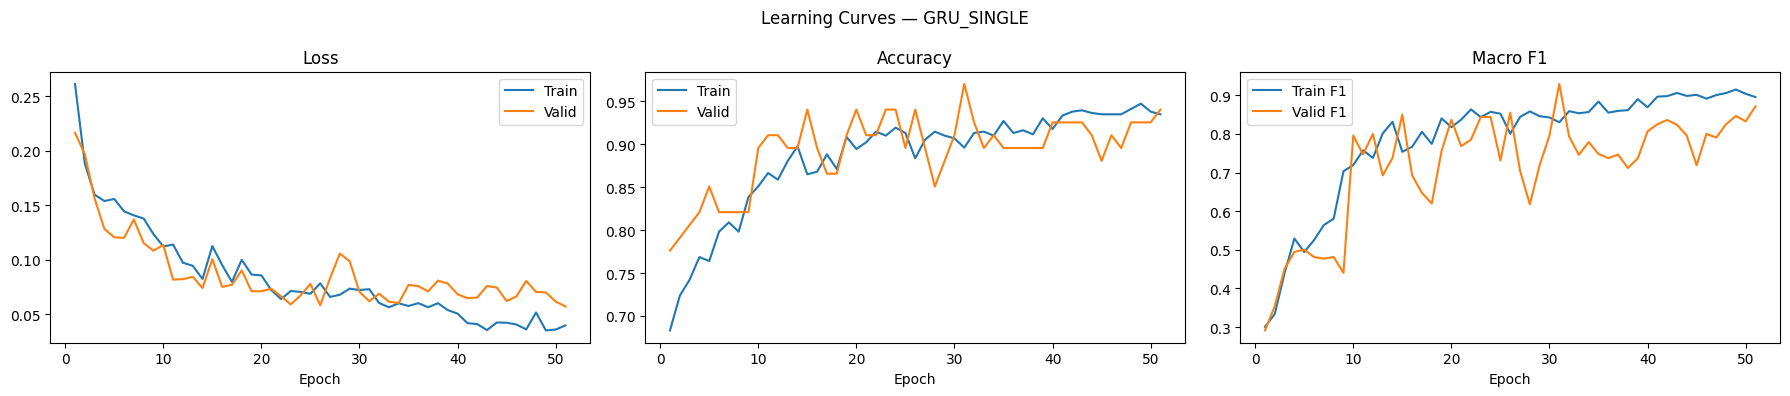

In [753]:
def plot_history(history: Dict[str, List[float]], title: str = 'Learning Curves'):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    axs[0].plot(epochs, history['train_loss'], label='Train')
    axs[0].plot(epochs, history['valid_loss'], label='Valid')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    axs[1].plot(epochs, history['train_accuracy'], label='Train')
    axs[1].plot(epochs, history['valid_accuracy'], label='Valid')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()

    axs[2].plot(epochs, history['train_f1'], label='Train F1')
    axs[2].plot(epochs, history['valid_f1'], label='Valid F1')
    axs[2].set_title('Macro F1')
    axs[2].set_xlabel('Epoch')
    axs[2].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


plot_history(best_history, title=f"Learning Curves — {best_run['run_name']}")



Best validation macro F1: 0.929
              precision    recall  f1-score   support

   high_pain       1.00      0.83      0.91         6
    low_pain       0.89      0.89      0.89         9
     no_pain       0.98      1.00      0.99        52

    accuracy                           0.97        67
   macro avg       0.96      0.91      0.93        67
weighted avg       0.97      0.97      0.97        67



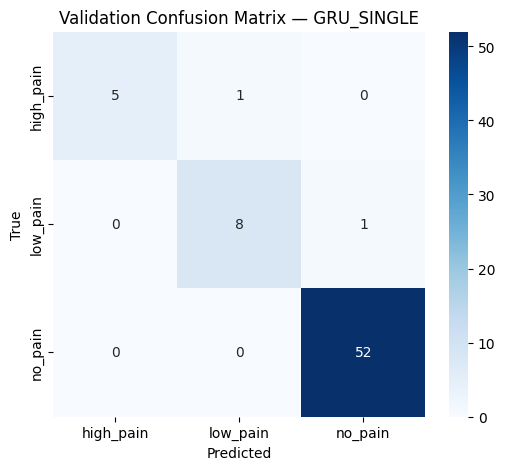

In [754]:
best_preds = best_run['preds']
best_targets = best_run['targets']
print(f"Best validation macro F1: {best_run['best_f1']:.3f}")
print(
    classification_report(
        best_targets,
        best_preds,
        target_names=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
    )
)

cf = confusion_matrix(best_targets, best_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cf,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
    yticklabels=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"Validation Confusion Matrix — {best_run['run_name']}")
plt.show()



In [755]:
test_dataset = TimeSeriesDataset(
    X_test_np,
    labels=None,
    window_size=None,
    mode='test',
    high_pain_targets=HIGH_PAIN_IDX,
)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False)

best_model.eval()
test_preds = []
best_config = best_run['config']
eval_window_size = best_config.get('eval_window_size', EVAL_WINDOW_SIZE)
eval_window_stride = best_config.get('eval_window_stride', EVAL_WINDOW_STRIDE)
eval_aggregation = best_config.get('eval_aggregation', EVAL_AGGREGATION)
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(DEVICE)
        with autocast_context():
            logits = forward_with_sliding_windows(
                best_model,
                inputs,
                eval_window_size,
                eval_window_stride,
                eval_aggregation,
            )
        test_preds.append(torch.argmax(logits, dim=1).cpu().numpy())

test_preds = np.concatenate(test_preds)
test_labels = [IDX2LABEL[idx] for idx in test_preds]

submission = pd.DataFrame({
    'sample_index': pd.unique(X_test_raw['sample_index']),
    'label': test_labels,
})
submission_filename = OUTPUT_DIR / f"submission_{best_run['run_name'].lower()}.csv"
submission.to_csv(submission_filename, index=False)
print(f"Saved submission to {submission_filename}")
submission.head()



Saved submission to /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/submission_gru_single.csv


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain


In [756]:
%tensorboard --logdir "/content/drive/MyDrive/[2025-2026]\ AN2DL/Challenge/outputs/logs"

UsageError: Line magic function `%tensorboard` not found.


## Next Steps

- Espandere `EXPERIMENT_CONFIGS` con ricerche random/grid su hidden size, depth, dropout, learning rate e scheduler per automatizzare l'hyperparameter tuning.
- Utilizzare `run_cross_validation` su più configurazioni e confrontare le metriche aggregate in `cv_summary`, esportando i risultati (CSV/LaTeX) per il report finale.
- Monitorare tutti i run con `%tensorboard --logdir outputs/logs`, salvando screenshot delle curve principali e confrontando tempi/risorse.
- Integrare tecniche di regularizzazione avanzate (label smoothing, mixup temporale, stochastic weight averaging) o layer di attention/pooling.
- Costruire ensemble sui checkpoint migliori (media delle probabilità o voting) prima della submission Kaggle definitiva.

